# Demo Convolutional Neural Network (CNN o ConvNet) para clasificar (atributo clase discreto) o estimar (atributo clase continuo)

In [1]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

import os
import csv

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [2]:
#@title Acceder al Drive

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [3]:

#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [4]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [5]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de CLASIFICACIÓN 

> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 38
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 37

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 12
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 13


In [6]:
#@title Preparar datos - convertir a matriz
cols = x_train.shape[1]

if (cols%2)==0:
  matrixShape = [2,(cols//2)]
else:
  matrixShape = [3,(cols//3)]
print("\n Forma de la matriz: ", matrixShape)

matrixTrain = []
matrixTest = []

# cambia la forma de la matriz
matrixTrain = x_train.reshape((len(x_train), matrixShape[0], matrixShape[1]))
matrixTest = x_test.reshape((len(x_test), matrixShape[0], matrixShape[1]))

print("\n Datos de entrada convertidos matriz: ")
print(" - matrixTrain (cant ejemplos, forma): ", matrixTrain.shape)
print(" - matrixTest (cant ejemplos, forma): ", matrixTest.shape)



 Forma de la matriz:  [2, 2]

 Datos de entrada convertidos matriz: 
 - matrixTrain (cant ejemplos, forma):  (112, 2, 2)
 - matrixTest (cant ejemplos, forma):  (38, 2, 2)


# Modelo:

Modelo creado con  6  capas:
Model: "ConvNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2, 2)]            0         
                                                                 
 c_conv_1 (Conv1D)           (None, 2, 8)              40        
                                                                 
 p_conv_1 (MaxPooling1D)     (None, 1, 8)              0         
                                                                 
 flat (Flatten)              (None, 8)                 0         
                                                                 
 lineal_1 (Dense)            (None, 8)                 72        
                                                                 
 output (Dense)              (None, 4)                 36        
                                                                 
Total params: 148 (592.00 Byte

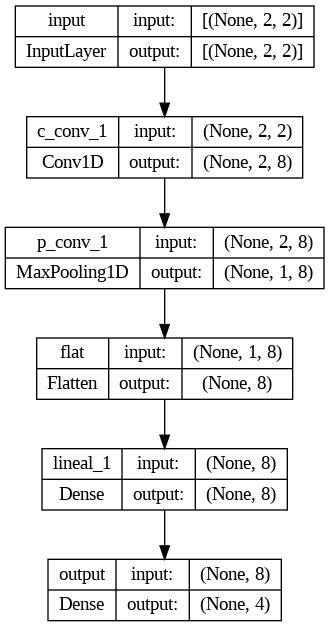

In [21]:
#@title Establecer modelo

#@markdown ### Parámetros de las capas ConvNet:
convNet_tamaño_kernel_N =  2 #@param {type:"integer"}
convNet_tamaño_pooling_M = 2 #@param {type:"integer"}
convNet_cantidad_capas_ocultas =  1#@param {type:"integer"}

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = '8' #@param {type:"string"}
#@markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_tipo_funcion = 'relu' #@param ['exponential', 'linear', 'relu', 'sigmoid', 'tanh' ]
lineal_porc_capa_DropOut = 0.4 #@param {type:"number"}

#@markdown ### Parámetros de la capa de Salida:
red_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.003 #@param {type: "number"}

## aplicación de los parámetros elegidos

# tamaño de los kernels y pooling (para simplificar son todas iguales)
if convNet_tamaño_kernel_N<1:
  convNet_tamaño_kernel_N = 1
cnn_kernel_shape = (convNet_tamaño_kernel_N)
if convNet_tamaño_pooling_M<1:
  convNet_tamaño_pooling_M=1
cnn_pooling_shape = (convNet_tamaño_pooling_M)

# indica la configuración para la parte Encoder
#   (cada elemento de las listas son la configuración de las capas Conv)
if convNet_cantidad_capas_ocultas<1:
  convNet_cantidad_capas_ocultas = 1
cnn_filters = []
for i in range(convNet_cantidad_capas_ocultas, 0, -1):
  cnn_filters.append( 2**(i+2) )
last_conv_layer_name = None
last_conv_layer_shape = None

# chequea configuración de drop out
if lineal_porc_capa_DropOut <= 0:
  lineal_porc_capa_DropOut = 0.10
elif lineal_porc_capa_DropOut > 0.9:
    lineal_porc_capa_DropOut = 0.9

# cantidad de neuronas ocultas
hidden_layers = []
for val in lineal_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  if val == "D":
    hidden_layers.append( "DropOut" )
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")


# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if esProblemaClasificacion:
  tipo_output_softMax = (red_tipo_capa_salida[:7] == 'softmax')
else:
  print("-- se considera salida lineal porque es problema de Estimación!")
  tipo_output_softMax = False


# define la arquitectura de capas de la CNN
# teniendo en cuenta la definición dada anteriomente
input_Lay =  tf.keras.layers.Input(shape=((matrixShape[0], matrixShape[1])), name='input') # capa de entrada
eachLay = input_Lay

auxName = 'conv_'
for i in range(len(cnn_filters)):

    # define el nombre de la capa oculta
    auxlayerName = 'conv_'+str(i+1)

    # agrega las capas ocultas de tipo Conv2D + MaxPooling
    eachLay =  tf.keras.layers.Conv1D(cnn_filters[i], cnn_kernel_shape, activation='relu', padding='same', name='c_'+auxlayerName)(eachLay)
    # determina nombre y shape de la capa conv2D
    last_conv_layer_name = 'c_'+auxlayerName
    last_conv_layer_shape = (eachLay.shape[1], eachLay.shape[2])
    ##print(last_conv_layer_name, last_conv_layer_shape, eachLay.shape)
    eachLay =  tf.keras.layers.MaxPooling1D(cnn_pooling_shape, padding='same', name='p_'+auxlayerName)(eachLay)

#  agrega capa Flatten
eachLay = tf.keras.layers.Flatten(name='flat')(eachLay)

# agrega capas lineales
auxName = 'lineal_'
auxId = 1
for val_hid in hidden_layers:

  if val_hid == "DropOut":
    auxlayerName = "d_"+str(auxId)
    auxId = auxId + 1
    eachLay =  tf.keras.layers.Dropout(lineal_porc_capa_DropOut,name=auxlayerName)(eachLay)
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn_"+str(auxId)
    auxId = auxId + 1
    eachLay =  tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dense(int(val_hid), activation=lineal_tipo_funcion, name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if esProblemaClasificacion and tipo_output_softMax:
    # se genera una capa softmax
    output_Lay = tf.keras.layers.Dense(units = len(CLASES), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay) # capa de salida

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# genera el modelo ConvNet
model = Model(input_Lay, output_Lay, name='ConvNet')
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    if esProblemaClasificacion:
      model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    else:
      model.compile(optimizer=opt, loss='mse', metrics=['RootMeanSquaredError'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)

In [22]:
#@title Entrenar

cant_epocas_entrenamiento = 50 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

activar_corte_por_estabilidad_val_loss = False #@param {type:"boolean"}

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(matrixTrain,
                                       (y_trainEnc if tipo_output_softMax else y_train),
                                       test_size=0.1, shuffle=True)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_val_loss:
  # se agrega un callBack para que corte
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=1,
      mode='min',
      baseline=None,
      restore_best_weights=True,
      start_from_epoch=5
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas,
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr)

print("\n>Entrenamiento Finalizado.")



> De los  112 ejemplos de entrenamiento: 
            se usan  100 ejemplos para entrenar 
            y  12 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/50
4/4 [==============================] - 2s 79ms/step - loss: 1.3838 - accuracy: 0.3400 - val_loss: 1.3869 - val_accuracy: 0.2500
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 1.3269 - accuracy: 0.3400 - val_loss: 1.3300 - val_accuracy: 0.2500
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 1.2752 - accuracy: 0.3500 - val_loss: 1.2937 - val_accuracy: 0.3333
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 1.2372 - accuracy: 0.5300 - val_loss: 1.2540 - val_accuracy: 0.4167
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1.1986 - accuracy: 0.4300 - val_loss: 1.2084 - val_accuracy: 0.3333
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 1.1594 - accuracy: 0.3400 - val_loss: 1.1592 - val_accuracy: 0.3333
Epo

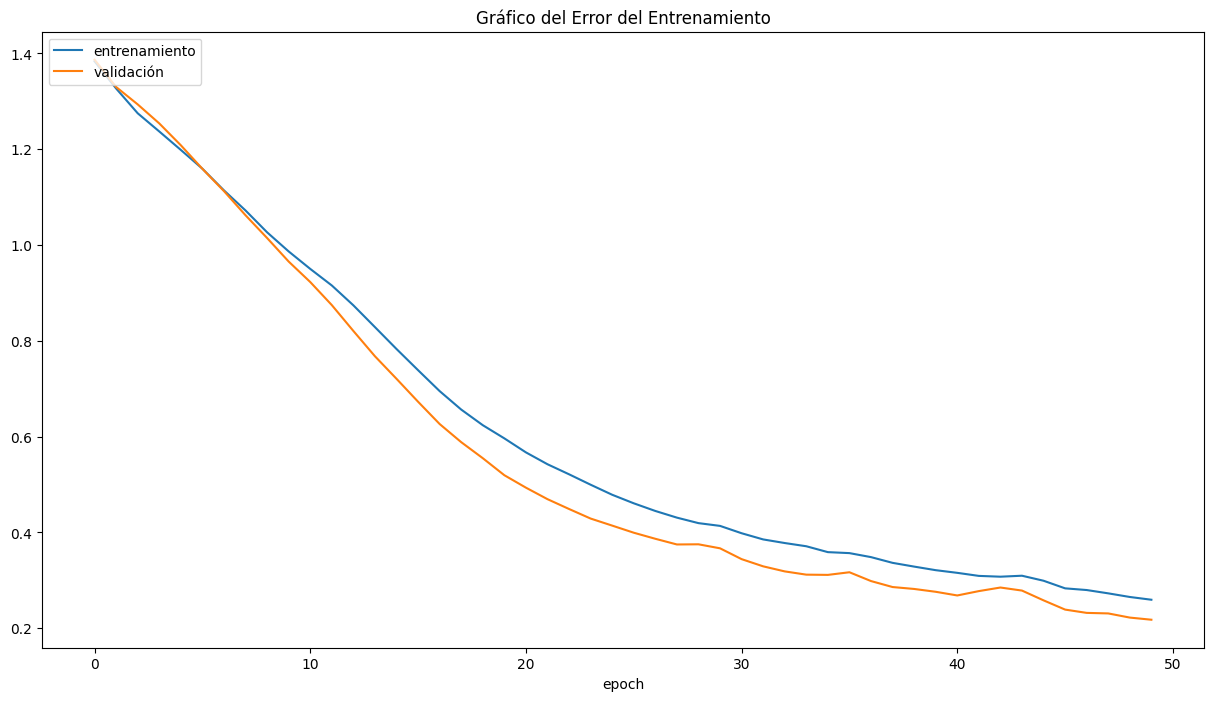

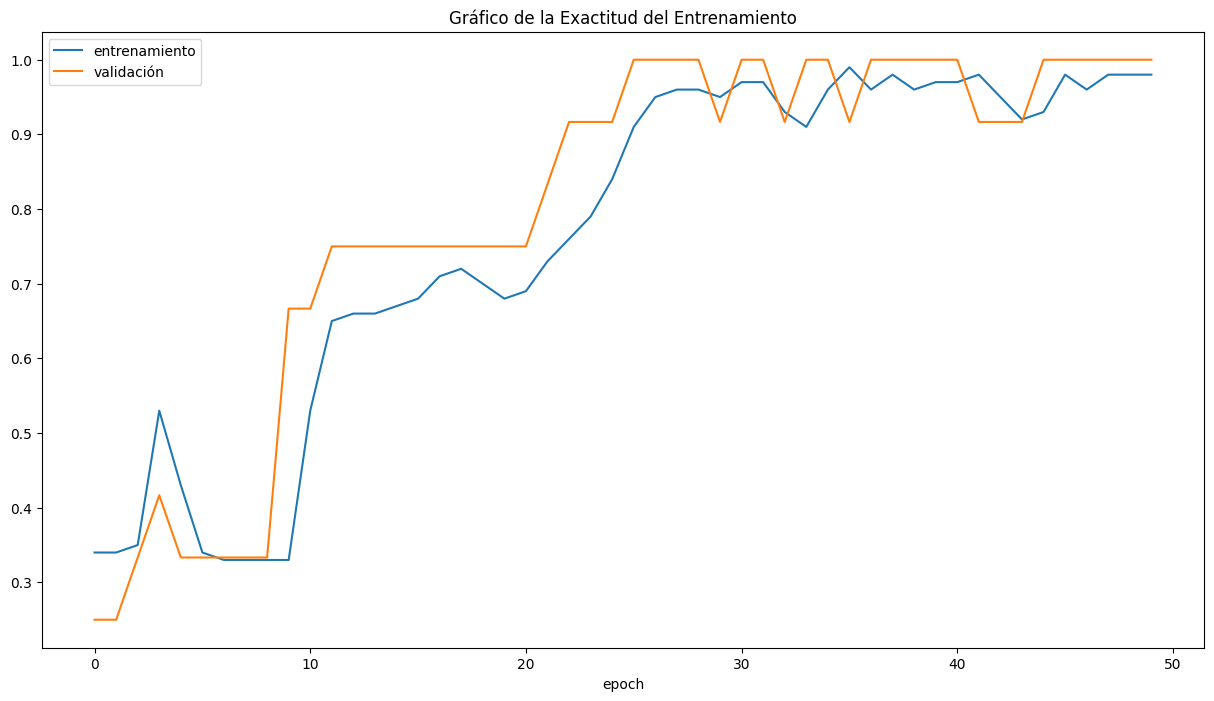

In [23]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8))
if esProblemaClasificacion:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Gráfico de la Exactitud del Entrenamiento')
else:
  plt.plot(history.history['root_mean_squared_error'])
  plt.plot(history.history['val_root_mean_squared_error'])
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')

plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        38
  Versicolor       1.00      0.95      0.97        37
   Virginica       0.95      1.00      0.97        37

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica  m:na
r:Setosa            38             0            0     0
r:Versicolor         0            35            2     0
r:Virginica          0             0           37     0
r:na                 0             0            0     0




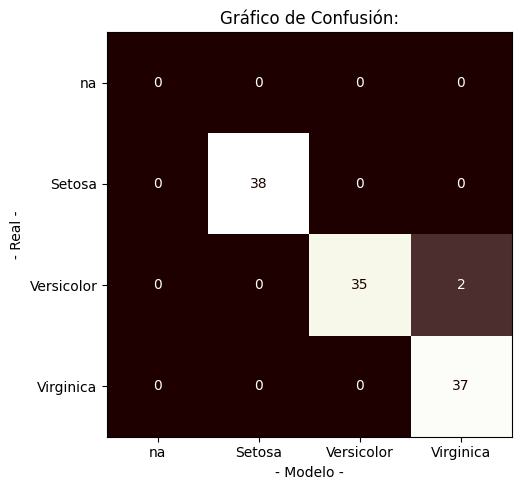

In [24]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
      else:
        print(" Clase Real / Clase Modelo [resultado]")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) +' / M: ' + str(clPred)
        strTitulo = strTitulo + " [ " + ("OK" if (clPred==clReal) else "ERROR!") + " ]"

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(matrixTrain, y_train, CLASES, umbral_clasificacion/100.0, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)
else:
  probarModelo_Estimacion(matrixTrain, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:


>Evaluación del Modelo: 
    - Error:  0.257
    - Exactitud:  94.74


*** Resultados con datos de Prueba: 
  Datos Entrada -> Clase Real / Clase Modelo [resultado]
  [[6.2 2.2]
 [4.5 1.5]]-> R: Versicolor / M: Virginica [ ERROR! ]
  [[5.6 3. ]
 [4.5 1.5]]-> R: Versicolor / M: Versicolor [ OK ]
  [[6.3 3.3]
 [4.7 1.6]]-> R: Versicolor / M: Versicolor [ OK ]
  [[5.6 2.9]
 [3.6 1.3]]-> R: Versicolor / M: Versicolor [ OK ]
  [[5.1 3.5]
 [1.4 0.2]]-> R: Setosa / M: Setosa [ OK ]
  [[5.9 3. ]
 [4.2 1.5]]-> R: Versicolor / M: Versicolor [ OK ]
  [[5.2 4.1]
 [1.5 0.1]]-> R: Setosa / M: Setosa [ OK ]
  [[6.4 3.2]
 [5.3 2.3]]-> R: Virginica / M: Virginica [ OK ]
  [[5.2 3.5]
 [1.5 0.2]]-> R: Setosa / M: Setosa [ OK ]
  [[4.9 3.1]
 [1.5 0.1]]-> R: Setosa / M: Setosa [ OK ]
  [[6.9 3.2]
 [5.7 2.3]]-> R: Virginica / M: Virginica [ OK ]
  [[6.7 3. ]
 [5.2 2.3]]-> R: Virginica / M: Virginica [ OK ]
  [[5.4 3.7]
 [1.5 0.2]]-> R: Setosa / M: Setosa [ OK ]
  [[6.9 3.1]
 [5.4 2.1]]-> R: Virginica / M: 

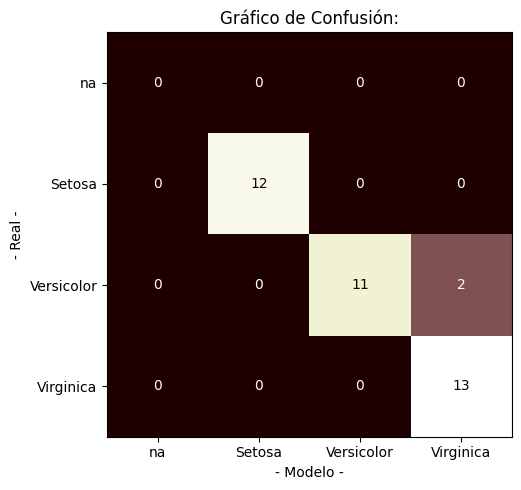

In [25]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = True #@param {type:"boolean"}

  # evalua al modelo entrenado
resEval = model.evaluate(matrixTest, (y_testEnc if tipo_output_softMax else y_test), verbose=0)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", round(resEval[0],3))
if esProblemaClasificacion:
  print("    - Exactitud: ", round(resEval[1]*100,2))
else:
  print("    - Distancia Media Cuadrática Mínima: ", round(resEval[1],3))

#print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(matrixTest, y_test, CLASES, umbral_clasificacion/100.0, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
else:
  probarModelo_Estimacion(matrixTest, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)


In [26]:
#@title Guardar Modelo entrenado

guardar_modelo = False #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/datosCNN'  #@param {type:"string"}

if guardar_modelo:

    # guarda el modelo entrenado
    model.save(path_modelo)
    print("\n-Modelo guardado en ", path_modelo,"\n")

    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"
      import joblib
      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", path_modelo,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo no guardado.
